# Predicting Loan Defaults

##### Aim: Help LendingClub, an online loan provider, to understand  who is likely to default and who they should lend to in the future.
------------------------
## Plan for predictive analysis - classification to predict the defaulter
 
#### A. Pre-modeling (data processing): 
1. import libraries


2. data import and exploration (summary statistics, vizualizations) 


3. data cleaning:
    - drop features with more than 50% of values missing,
    - drop features containing just one constant value,
    - drop categorical features showing high cardinality (= too many levels) that are not needed for machine learning and such as not worth further manipulation (eg. "binning")
    - "regex" operations on Python object values (eg. get rid of '%' symbol)
    - transform data types where needed (eg. str -> float)
    
    
    
4. feature pre-selection based on data exploration


5. feauture engineering:
    - set target variable "loan_status" as binary (0 = default, 1 = paid)
    - "binning" categorical features (lowering the cardinality, eg. by binning values into quartile intervals results into just 4 levels and data less affected by outliers)
    - dummying (models can only handle numeric features -> create dummies for categorical values)

    
6. feature selection 
    - perform train/test split to avoid overfitting!
    - on train and test datasets separatelly:
        - deal with missing values - NA imputation (models can not handle missing data)
        - further feature reduction 
            - based on variation, 
            - based on correlation (between features, and between features and target variable)

#### B. Model building - machine learning binary classification model for prediction of loan default: Logistic regression, Decision Tree, Random Forest
- target variable: loan_status (binary variable)
- feature matrix (explanatory variables): all features selected and modified in the pre-modeling step
- null model for cross validation
- build models on default classification threshold 0.5 (Logistic regression, Decision Tree)
- access model performance 
    - calculate metrics: accuracy, sensitivity (precision), specificity (=recall), AUC
    - visualize ROC
- compare the metrics to see what model might be the best
- adjust values of metrics (precision and recall) by modifying the classification threshold
- choose the best model = final trained model
- showcase the model - make an individual prediction for a client

#### C. Exploratory data analysis
- conclude with listing out which are the main variables that have direct and clear impact on client being likely to pay the loan, and being likely to fail to pay the loan

# A. Pre-modeling

## 1 Import Libraries

In [1]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd

# remove scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# vizualizations
import matplotlib.pyplot as plt
import seaborn as sns

## 2 Data import and Exploration

In [3]:
## data import and date types specification
data = pd.read_csv("data/lending_club_loans.csv", 
                   dtype={36: float, 
                         48: str,
                         "term": str                        
                         })

# print first 5 observations (with all the columns) 
pd.set_option('display.max_columns', None)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501.00,1296599.00,5000.00,5000.00,4975.00,36 months,10.65%,162.87,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgrade...,credit_card,Computer,860xx,AZ,27.65,0.00,Jan-1985,735.00,739.00,1.00,nan,nan,3.00,0.00,13648.00,83.7%,9.00,0.00,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,NaN,Sep-2016,744.00,740.00,0.00,nan,1.00,INDIVIDUAL,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
1,1077430.00,1314167.00,2500.00,2500.00,2500.00,60 months,15.27%,59.83,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,1.00,0.00,Apr-1999,740.00,744.00,5.00,nan,nan,3.00,0.00,1687.00,9.4%,4.00,0.00,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2016,499.00,0.00,0.00,nan,1.00,INDIVIDUAL,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
2,1077175.00,1313524.00,2400.00,2400.00,2400.00,36 months,15.96%,84.33,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.00,Nov-2001,735.00,739.00,2.00,nan,nan,2.00,0.00,2956.00,98.5%,10.00,0.00,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,NaN,Sep-2016,719.00,715.00,0.00,nan,1.00,INDIVIDUAL,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
3,1076863.00,1277178.00,10000.00,10000.00,10000.00,36 months,13.49%,339.31,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for proper...,other,person

In [4]:
# get size of the data set
data.shape

(42538, 114)

In [5]:
# see data types of all features
data.dtypes.to_dict()

{'id': dtype('float64'),
 'member_id': dtype('float64'),
 'loan_amnt': dtype('float64'),
 'funded_amnt': dtype('float64'),
 'funded_amnt_inv': dtype('float64'),
 'term': dtype('O'),
 'int_rate': dtype('O'),
 'installment': dtype('float64'),
 'sub_grade': dtype('O'),
 'emp_title': dtype('O'),
 'emp_length': dtype('O'),
 'home_ownership': dtype('O'),
 'annual_inc': dtype('float64'),
 'verification_status': dtype('O'),
 'issue_d': dtype('O'),
 'loan_status': dtype('O'),
 'pymnt_plan': dtype('O'),
 'url': dtype('O'),
 'desc': dtype('O'),
 'purpose': dtype('O'),
 'title': dtype('O'),
 'zip_code': dtype('O'),
 'addr_state': dtype('O'),
 'dti': dtype('float64'),
 'delinq_2yrs': dtype('float64'),
 'earliest_cr_line': dtype('O'),
 'fico_range_low': dtype('float64'),
 'fico_range_high': dtype('float64'),
 'inq_last_6mths': dtype('float64'),
 'mths_since_last_delinq': dtype('float64'),
 'mths_since_last_record': dtype('float64'),
 'open_acc': dtype('float64'),
 'pub_rec': dtype('float64'),
 'revo

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Columns: 114 entries, id to total_il_high_credit_limit
dtypes: float64(92), object(22)
memory usage: 37.0+ MB


In [7]:
# summary statistics for each column
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42531.00,42535.00,42506.00,42535.00,42535.00,42506.00,15609.00,3651.00,42506.00,42506.00,42535.00,42506.00,42538.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42390.00,0.00,42535.00,0.00,0.00,0.00,42506.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42390.00,42506.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41170.00,42430.00,0.00,0.00,0.00,0.00
mean,664579.85,825702.55,11089.72,10821.59,10139.83,322.62,69136.56,13.37,0.15,713.05,717.05,1.08,35.02,59.18,9.34,0.06,14297.86,22.12,0.00,11.85,11.82,12005.64,11298.59,9664.27,2239.55,1.52,100.31,13.96,2612.72,689.31,676.38,0.00,nan,1.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.05,0.00,nan,nan,nan,nan
std,219302.22,279540.91,7410.94,7146.91,7131.69,208.93,64096.35,6.73,0.51,36.19,36.19,1.53,22.42,47.15,4.50,0.25,22018.44,11.59,0.01,125.38,125.06,9067.24,9010.32,7087.47,2583.72,7.83,718.08,159.62,4385.20,80.20,119.01,0.00,nan,0.00,nan,nan,nan,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,29.36,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.21,0.00,nan,nan,nan,nan
min,54734.00,70473.00,500.00,500.00,0.00,15.67,1896.00,0.00,0.00,610.00,614.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,1.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
25%,498392.50,638479.50,5200.00,5000.00,4950.00,165.52,40000.00,8.20,0.00,685.00,689.00,0.00,17.00,0.00,6.00,0.00,3635.00,13.00,0.00,0.00,0.00,5462.79,4791.41,4400.00,657.10,0.00,0.00,0.00,211.37,644.00,640.00,0.00,nan,1.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
50%,644250.00,824178.00,9700.00,9600.00,8500.00,277.69,59000.00,13.47,0.00,710.00,714.00,1.00,33.00,85.00,9.00,0.00,8821.00,20.00,0.00,0.00,0.00

In [8]:
## missing values

# function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'missing_values', 1 : '%_of_total_values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '%_of_total_values', ascending=False).round(1)
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# save it as a new DataFrame
features_with_mis_val = missing_values_table(data)

# convert row names into column
features_with_mis_val.index.name = 'feature_name'
features_with_mis_val.reset_index(inplace = True)

# print the first 50 observations
features_with_mis_val.head(60)

,feature_name,missing_values,%_of_total_values
0,dti_joint,42538,100.00
1,annual_inc_joint,42538,100.00
2,mo_sin_old_rev_tl_op,42538,100.00
3,mo_sin_old_il_acct,42538,100.00
4,bc_util,42538,100.00
5,bc_open_to_buy,42538,100.00
6,avg_cur_bal,42538,100.00
7,acc_open_past_24mths,42538,100.00
8,inq_last_12m,42538,100.00
9,total_cu_tl,42538,100.00


In [9]:
# close look into number of levels of categorical variables
for col_name in data.columns:
    if data[col_name].dtypes == 'object':
        unique_cat = len(data[col_name].unique()) - 1
        print("'{col_name}' : {unique_cat} unique categories".format(
                col_name = col_name, unique_cat = unique_cat))

'term' : 2 unique categories
'int_rate' : 394 unique categories
'sub_grade' : 35 unique categories
'emp_title' : 30446 unique categories
'emp_length' : 11 unique categories
'home_ownership' : 5 unique categories
'verification_status' : 3 unique categories
'issue_d' : 55 unique categories
'loan_status' : 9 unique categories
'pymnt_plan' : 2 unique categories
'url' : 42535 unique categories
'desc' : 28948 unique categories
'purpose' : 14 unique categories
'title' : 20969 unique categories
'zip_code' : 837 unique categories
'addr_state' : 50 unique categories
'earliest_cr_line' : 530 unique categories
'revol_util' : 1119 unique categories
'last_pymnt_d' : 106 unique categories
'next_pymnt_d' : 101 unique categories
'last_credit_pull_d' : 111 unique categories
'application_type' : 1 unique categories


In [10]:
# take a look at the levels of outcome variable "loan_status" (current status of the loan)
print(data["loan_status"].value_counts())

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64


## 3 Data cleaning
- drop features with more than 50% of values missing,
- drop features containing just one constant value,
- drop categorical features with high cardinality (= too many levels) that are not needed for machine learning and such as not worth further manipulation (eg. "binning")
- transform data types (eg. str to float)
- "regex" operations on Python object values (eg. get rid of '%' symbol), transform data type (str -> float) 

In [11]:
# get vector (series) of features that have more than 50% of values missing
NA_features = features_with_mis_val.loc[features_with_mis_val["%_of_total_values"] > 50].loc[:, "feature_name"].copy()

NA_features.reset_index(drop = True, inplace = True)

NA_features.shape, NA_features.head()

((57,),
 0               dti_joint
 1        annual_inc_joint
 2    mo_sin_old_rev_tl_op
 3      mo_sin_old_il_acct
 4                 bc_util
 Name: feature_name, dtype: object)

In [12]:
# using the defined series, drop such features from the data frame and display the dimension
data.drop(columns = NA_features, inplace = True)

data.shape

(42538, 57)

In [13]:
# drop also categorical features with just 1 level, or toooo many levels
# drop features "id" and "member_id" as those are not needed for machine learning
# drop feature "pymnt_plan" as it has two levels where one of the levels has just 1 value
# drop feature "sub_grade" as int_rate has the real interest rate value

data.drop(columns = ["emp_title",
                    "url",
                    "desc",
                    "title",
                    "zip_code",
                    "earliest_cr_line",
                    "last_pymnt_d",
                    "last_credit_pull_d",
                    "application_type",
                    "id",
                    "member_id",
                    "pymnt_plan",
                    "sub_grade"], inplace = True)

data.shape

(42538, 44)

In [14]:
# print all remaining features
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens'],
      dtype='object')

In [15]:
# "loan_status" - target variable
# filter "Current", "In Grace Period", both "Late.." and "Default" observations
# ??? Does not meet the credit policy. Status:Fully Paid - googled: credit policy was updated after this loan was listed but before it issued
data = data.loc[(data["loan_status"].isin(["Fully Paid", "Charged Off"]))].copy()

print(data["loan_status"].value_counts())

Fully Paid     33586
Charged Off     5653
Name: loan_status, dtype: int64


In [16]:
# "int_rate"
# remove '%' from "int_rate"
data['int_rate'] = data['int_rate'].str[:-1].astype(float)

# "issue_d"
# 55 levels! -> get rid of month, keep just year
data['issue_d'] = data['issue_d'].str[4:len('issue_d') + 1].astype("category")

# "revol_util"
# remove '%' from "revol_util"
data['revol_util'] = data['revol_util'].str[:-1].astype(float)

data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.00,5000.00,4975.00,36 months,10.65,162.87,10+ years,RENT,24000.00,Verified,2011,Fully Paid,credit_card,AZ,27.65,0.00,735.00,739.00,1.00,3.00,0.00,13648.00,83.70,9.00,0.00,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,744.00,740.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,2500.00,2500.00,2500.00,60 months,15.27,59.83,< 1 year,RENT,30000.00,Source Verified,2011,Charged Off,car,GA,1.00,0.00,740.00,744.00,5.00,3.00,0.00,1687.00,9.40,4.00,0.00,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,499.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,2400.00,2400.00,2400.00,36 months,15.96,84.33,10+ years,RENT,12252.00,Not Verified,2011,Fully Paid,small_business,IL,8.72,0.00,735.00,739.00,2.00,2.00,0.00,2956.00,98.50,10.00,0.00,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,719.00,715.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,10000.00,10000.00,10000.00,36 months,13.49,339.31,10+ years,RENT,49200.00,Source Verified,2011,Fully Paid,other,CA,20.00,0.00,690.00,694.00,1.00,10.00,0.00,5598.00,21.00,37.00,0.00,0.00,0.00,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,604.00,600.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
5,5000.00,5000.00,5000.00,36 months,7.90,156.46,3 years,RENT,36000.00,Source Verified,2011,Fully Paid,wedding,AZ,11.20,0.00,730.00,734.00,3.00,9.00,0.00,7963.00,28.30,12.00,0.00,0.00,0.00,5632.21,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,679.00,675.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


## 4 Feature pre-selection
- generate summary report and based on it reduce dimension
- why reduction? curse of dimensionality

In [17]:
# I've done some basic cleaning that led to some significant dimension reduction in the raw data set (114 -> 44)
# get the report generated
import pandas_profiling

# pandas_profiling.ProfileReport(data)

In [18]:
data_clean = data.drop(columns = [#??? "df_index",
                    "total_rec_int",
                    "total_rec_late_fee",
                    "collection_recovery_fee",
                    "total_acc"]).copy() #similar to "open_acc"

data_clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.00,5000.00,4975.00,36 months,10.65,162.87,10+ years,RENT,24000.00,Verified,2011,Fully Paid,credit_card,AZ,27.65,0.00,735.00,739.00,1.00,3.00,0.00,13648.00,83.70,0.00,0.00,0.00,5863.16,5833.84,5000.00,0.00,171.62,744.00,740.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,2500.00,2500.00,2500.00,60 months,15.27,59.83,< 1 year,RENT,30000.00,Source Verified,2011,Charged Off,car,GA,1.00,0.00,740.00,744.00,5.00,3.00,0.00,1687.00,9.40,0.00,0.00,0.00,1008.71,1008.71,456.46,117.08,119.66,499.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,2400.00,2400.00,2400.00,36 months,15.96,84.33,10+ years,RENT,12252.00,Not Verified,2011,Fully Paid,small_business,IL,8.72,0.00,735.00,739.00,2.00,2.00,0.00,2956.00,98.50,0.00,0.00,0.00,3005.67,3005.67,2400.00,0.00,649.91,719.00,715.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,10000.00,10000.00,10000.00,36 months,13.49,339.31,10+ years,RENT,49200.00,Source Verified,2011,Fully Paid,other,CA,20.00,0.00,690.00,694.00,1.00,10.00,0.00,5598.00,21.00,0.00,0.00,0.00,12231.89,12231.89,10000.00,0.00,357.48,604.00,600.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
5,5000.00,5000.00,5000.00,36 months,7.90,156.46,3 years,RENT,36000.00,Source Verified,2011,Fully Paid,wedding,AZ,11.20,0.00,730.00,734.00,3.00,9.00,0.00,7963.00,28.30,0.00,0.00,0.00,5632.21,5632.21,5000.00,0.00,161.03,679.00,675.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


## 5 Feature engineering
- set target variable "loan_status" as binary (0 = default, 1 = paid)
- "binning" categorical features (lowering the cardinality, eg. by binning values into quartile intervals results into just 4 levels and data less affected by outliers)
- dummying (models can only handle numeric features -> create dummies for categorical values)

In [19]:
# make outcome variable binary: assign 1 if loan "Fully Paid", 0 if "Charged Off"
data_clean.loc[:, "loan_status"] = np.where(data_clean["loan_status"] == "Fully Paid", 1, 0)

# print values counts -> imbalanced data set
print(data_clean["loan_status"].value_counts())

1    33586
0     5653
Name: loan_status, dtype: int64


In [20]:
# "emp_length"

# print number of values in each category
# print(data_clean["emp_length"].value_counts())

# binning categorical values
# define function that will pick a label according to the value
def label_years (row):
    if row['emp_length'] in ["< 1 year"]:
        return '< 1 year'
    if row['emp_length'] in ["1 year", "2 years"]:
        return '1 - 2 years'
    if row['emp_length'] in ["3 years", "4 years", "5 years"]:
        return '3 - 5 years'
    if row['emp_length'] in ["6 years", "7 years", "8 years", "9 years"]:
        return '6 - 9 years'
    return '10+ years'

# use it to add a new column with the label to the data frame 
data_clean['emp_length'] = data_clean.apply(lambda row: label_years(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["emp_length"].value_counts())

3 - 5 years    10698
10+ years       9774
1 - 2 years     7563
6 - 9 years     6648
< 1 year        4556
Name: emp_length, dtype: int64


In [21]:
# "delinq_2yrs"

# convert float to categorical
data_clean["delinq_2yrs"] = data_clean["delinq_2yrs"].astype('category')

# binning categorical values
def label_delinq (row):
    if row['delinq_2yrs'] == 0.00:
        return '0'
    if row['delinq_2yrs'] == 1.00:
        return '1'
    return '2+'

data_clean['delinq_2yrs'] = data_clean.apply(lambda row: label_delinq(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["delinq_2yrs"].value_counts())

0     34975
1      3266
2+      998
Name: delinq_2yrs, dtype: int64


In [22]:
# "fico_range_high" and "fico_range_low"

# create new feature "fico_range" as an average of these two
data_clean["fico_range"] = (data_clean["fico_range_high"] + data_clean["fico_range_low"]) / 2

# drop the two features
data_clean.drop(columns = ["fico_range_high",
                          "fico_range_low"], inplace = True)

In [23]:
# "last_fico_range_high" and "last_fico_range_low"

# create new feature "last_fico_range" as an average of these two
data_clean["last_fico_range"] = (data_clean["last_fico_range_high"] + data_clean["last_fico_range_low"]) / 2

# drop the two features
data_clean.drop(columns = ["last_fico_range_high",
                          "last_fico_range_low"], inplace = True)

In [24]:
# "inq_last_6mths"

# convert float to categorical
data_clean["inq_last_6mths"] = data_clean["inq_last_6mths"].astype('category')

# binning categorical values
def label_delinq (row):
    if row['inq_last_6mths'] == 0.00:
        return '0'
    if row['inq_last_6mths'] == 1.00:
        return '1'
    return '2+'

data_clean['inq_last_6mths'] = data_clean.apply(lambda row: label_delinq(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["inq_last_6mths"].value_counts())

0     19060
1     10823
2+     9356
Name: inq_last_6mths, dtype: int64


In [25]:
# "open_acc"

# produce a Categorical object indicating quantile membership for each data point
bin_labels_open_acc = ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']

data_clean['open_acc_quartile'] = pd.qcut(data_clean['open_acc'],
                                                  q = [0, .25, .5, .75, 1],
                                                  labels = bin_labels_open_acc)

# drop the two original feature
data_clean.drop(columns = ["open_acc"], inplace = True)

print(data_clean["open_acc_quartile"].value_counts())

2nd quartile    11528
1st quartile    11475
4th quartile     8119
3rd quartile     8117
Name: open_acc_quartile, dtype: int64


In [26]:
# "pub_rec"

# binning categorical values
def label_pub_rec (row):
    if row['pub_rec'] == 0.00:
        return '0'
    return '1+'

data_clean['pub_rec'] = data_clean.apply(lambda row: label_pub_rec(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["pub_rec"].value_counts())

0     37136
1+     2103
Name: pub_rec, dtype: int64


In [27]:
# "recoveries"

def label_recoveries (row):
    if row['recoveries'] == 0.00:
        return '0'
    return '1+'

data_clean['recoveries'] = data_clean.apply(lambda row: label_recoveries(row), axis=1)

data_clean['recoveries'] = data_clean['recoveries'].astype('category')

# print updated categories and number of values in each category
print(data_clean["recoveries"].value_counts())

0     34984
1+     4255
Name: recoveries, dtype: int64


In [28]:
data_clean.shape

(39239, 38)

In [29]:
data_clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,revol_util,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_range,last_fico_range,open_acc_quartile
0,5000.00,5000.00,4975.00,36 months,10.65,162.87,10+ years,RENT,24000.00,Verified,2011,1,credit_card,AZ,27.65,0,1,0,13648.00,83.70,0.00,0.00,0.00,5863.16,5833.84,5000.00,0,171.62,0.00,1.00,0.00,0.00,0.00,0.00,0.00,737.00,742.00,1st quartile
1,2500.00,2500.00,2500.00,60 months,15.27,59.83,< 1 year,RENT,30000.00,Source Verified,2011,0,car,GA,1.00,0,2+,0,1687.00,9.40,0.00,0.00,0.00,1008.71,1008.71,456.46,1+,119.66,0.00,1.00,0.00,0.00,0.00,0.00,0.00,742.00,249.50,1st quartile
2,2400.00,2400.00,2400.00,36 months,15.96,84.33,10+ years,RENT,12252.00,Not Verified,2011,1,small_business,IL,8.72,0,2+,0,2956.00,98.50,0.00,0.00,0.00,3005.67,3005.67,2400.00,0,649.91,0.00,1.00,0.00,0.00,0.00,0.00,0.00,737.00,717.00,1st quartile
3,10000.00,10000.00,10000.00,36 months,13.49,339.31,10+ years,RENT,49200.00,Source Verified,2011,1,other,CA,20.00,0,1,0,5598.00,21.00,0.00,0.00,0.00,12231.89,12231.89,10000.00,0,357.48,0.00,1.00,0.00,0.00,0.00,0.00,0.00,692.00,602.00,3rd quartile
5,5000.00,5000.00,5000.00,36 months,7.90,156.46,3 - 5 years,RENT,36000.00,Source Verified,2011,1,wedding,AZ,11.20,0,2+,0,7963.00,28.30,0.00,0.00,0.00,5632.21,5632.21,5000.00,0,161.03,0.00,1.00,0.00,0.00,0.00,0.00,0.00,732.00,677.00,2nd quartile


In [30]:
## dummying
data_dummies = pd.get_dummies(data_clean, drop_first = True)

data_dummies.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,revol_bal,revol_util,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_range,last_fico_range,term_60 months,emp_length_10+ years,emp_length_3 - 5 years,emp_length_6 - 9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_2008,issue_d_2009,issue_d_2010,issue_d_2011,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,delinq_2yrs_1,delinq_2yrs_2+,inq_last_6mths_1,inq_last_6mths_2+,pub_rec_1+,recoveries_1+,open_acc_quartile_2nd quartile,open_acc_quartile_3rd quartile,open_acc_quartile_4th quartile
0,5000.00,5000.00,4975.00,10.65,162.87,24000.00,1,27.65,13648.00,83.70,0.00,0.00,0.00,5863.16,5833.84,5000.00,171.62,0.00,1.00,0.00,0.00,0.00,0.00,0.00,737.00,742.00,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2500.00,2500.00,2500.00,15.27,59.83,30000.00,0,1.00,1687.00,9.40,0.00,0.00,0.00,1008.71,1008.71,456.46,119.66,0.00,1.00,0.00,0.00,0.00,0.00,0.00,742.00,249.50,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,2400.00,2400.00,2400.00,15.96,84.33,12252.00,1,8.72,2956.00,98.50,0.00,0.00,0.00,3005.67,3005.67,2400.00,649.91,0.00,1.00,0.00,0.00,0.00,0.00,0.00,737.00,717.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,10000.00,10000.00,10000.00,13.49,339.31,49200.00,1,20.00,5598.00,21.00,0.00,0.00,0.00,12231.89,12231.89,10000.00,357.48,0.00,1.00,0.00,0.00,0.00,0.00,0.00,692.00,602.00,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,5000.00,5000.00,5000.00,7.90,156.46,36000.00,1,11.20,7963.00,28.30,0.00,0.00,0.00,5632.21,5632.21,5000.00,161.03,0.00,1.00,0.00,0.00,0.00,0.00,0.00,732.00,677.00,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [31]:
data_dummies.shape

(39239, 112)

## 6 Feature selection
- perform train/test split to avoid overfitting!
- on train and test datasets separatelly:
		- deal with missing values - NA imputation (models can not handle missing data)
		- perform further feature reduction 
            - based on variation, 
            - based on correlation (between features, and between features and target variable)

In [32]:
# assign X as a DataFrame of features (explanatory matrix), and y as Series (Outcome variable)
X = data_dummies.drop(columns = "loan_status")
y = data_dummies["loan_status"]

In [33]:
# split data into train and test
# the train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

X_train.shape, X_test.shape

((31391, 111), (7848, 111))

In [34]:
# NA imputation with median of X_train and X_test separatelly to avoid overfitting!

# note. anything that is done to pre-process or process my data, such as imputing missing values, should be done on the training set alone.
# And then the same on the test set.

# impute missing values based on the median of each column
X_train = X_train.apply(lambda x: x.fillna(x.median()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()),axis=0)

X_train.shape, X_test.shape

((31391, 111), (7848, 111))

### 6.1. Filter features by variation

In [35]:
# first let's look at the variance in my train data set
X_train.var()

loan_amnt                        54599896.02
funded_amnt                      50710138.42
funded_amnt_inv                  49808883.98
int_rate                               13.81
installment                         43161.07
                                     ...    
pub_rec_1+                              0.05
recoveries_1+                           0.10
open_acc_quartile_2nd quartile          0.21
open_acc_quartile_3rd quartile          0.16
open_acc_quartile_4th quartile          0.16
Length: 111, dtype: float64

In [36]:
# feature selector that removes all zero-variance features (i. e. features that only contain one constant)
# note. this feature selection algorithm looks only at the features (X), not the desired outputs (y)
from sklearn.feature_selection import VarianceThreshold

var_thres = VarianceThreshold(threshold = 0)
var_thres.fit(X_train)

VarianceThreshold(threshold=0)

In [37]:
# generate boolean vector where 'False' are the features with zero-variance and such as need to be removed
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [38]:
# pull out those features that are "False" and count them (list comprehensions syntax)
constant_columns = [column for column in X_train.columns
                   if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

9


In [39]:
# print out zero-variance features
for features in constant_columns:
    print(features)

initial_list_status
out_prncp
out_prncp_inv
collections_12_mths_ex_med
policy_code
acc_now_delinq
chargeoff_within_12_mths
delinq_amnt
tax_liens


In [40]:
# and drop them from both train and test feature matrices
X_train.drop(columns = constant_columns, inplace = True)
X_test.drop(columns = constant_columns, inplace = True)

X_train.shape, X_test.shape

((31391, 102), (7848, 102))

### 6.2. Filter features by correlation
- using Pearson Correlation

#### 6.2.1 correlation between features (explanatory variables)
- assumtion for regression is that there isn't too much correlation between explanatory variables

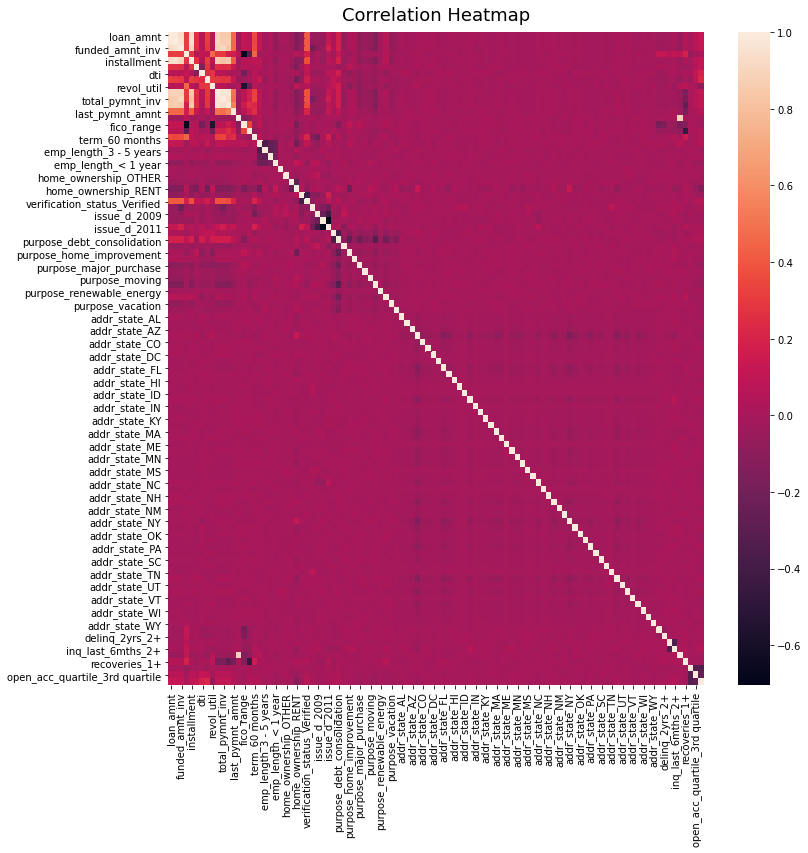

In [41]:
# so eg. if there is two features that are highly corellated (above set threshold), one should be dropped as only one is needed in the model
# it's again to prevent model overfitting

# visualize correlation with a heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
corr_heatmap = sns.heatmap(X_train.corr())
corr_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [42]:
# create a function that selects highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [43]:
# find features that have correlation higher than 0.91 (to keep just one of them)
corr_features = correlation(X_train, 0.91)
len(set(corr_features))

5

In [44]:
corr_features

{'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'total_pymnt_inv',
 'total_rec_prncp'}

In [45]:
# set pandas to see the whole correlation matrix
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
X_train.corr()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,pub_rec_bankruptcies,fico_range,last_fico_range,term_60 months,emp_length_10+ years,emp_length_3 - 5 years,emp_length_6 - 9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_2008,issue_d_2009,issue_d_2010,issue_d_2011,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,delinq_2yrs_1,delinq_2yrs_2+,inq_last_6mths_1,inq_last_6mths_2+,pub_rec_1+,recoveries_1+,open_acc_quartile_2nd quartile,open_acc_quartile_3rd quartile,open_acc_quartile_4th quartile
loan_amnt,1.00,0.98,0.94,0.31,0.93,0.26,0.06,0.31,0.06,0.88,0.85,0.85,0.46,-0.03,0.12,0.08,0.36,0.10,-0.02,0.03,-0.08,-0.00,-0.00,-0.04,-0.15,-0.09,0.42,-0.05,-0.06,-0.05,0.11,0.02,0.18,-0.05,0.01,0.03,-0.10,-0.05,-0.07,-0.14,-0.01,0.07,-0.07,-0.03,0.01,-0.01,-0.01,0.01,0.00,0.01,0.01,-0.01,-0.01,0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.00,-0.00,-0.01,-0.00,0.00,-0.01,0.00,-0.01,-0.01,-0.01,-0.01,0.01,-0.01,0.01,0.02,-0.01,-0.00,0.00,-0.01,0.00,-0.01,-0.01,-0.02,-0.00,-0.01,-0.00,0.02,-0.00,0.01,-0.01,-0.01,0.00,-0.01,-0.00,-0.02,-0.02,-0.01,0.01,-0.05,0.05,0.00,0.08,0.12
funded_amnt,0.98,1.00,0.96,0.31,0.96,0.26,0.06,0.31,0.07,0.90,0.87,0.87,0.47,-0.03,0.11,0.08,0.34,0.10,-0.01,0.03,-0.08,-0.00,-0.00,-0.04,-0.15,-0.08,0.41,-0.06,-0.05,-0.07,0.13,0.02,0.19,-0.05,0.01,0.02,-0.10,-0.05,-0.07,-0.14,-0.01,0.07,-0.07,-0.02,0.01,-0.01,-0.01,0.01,0.00,0.01,0.01,-0.01,-0.01,0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.01,-0.00,0.00,-0.01,0.00,-0.01,-0.01,-0.01,-0.01,0.01,-0.01,0.01,0.02,-0.01,-0.00,0.00,-0.01,0.00,-0.01,-0.01,-0.02,-0.00,-0.01,-0.01,0.02,-0.00,0.01,-0.01,-0.00,0.00,-0.00,-0.00,-0.02,-0.02,-0.01,0.01,-0.05,0.05,0.00,0.07,0.12
funded_amnt_inv,0.94,0.96,1.00,0.30,0.91,0.25,0.07,0.29,0.07,0.88,0.91,0.84,0.46,-0.03,0.11,0.09,0.36,0.11,-0.01,0.03,-0.08,-0.01,-0.02,-0.04,-0.15,-0.06,0.41,-0.21,-0.08,-0.04,0.19,0.02,0.19,-0.06,0.01,0.03,-0.09,-0.05,-0.07,-0.14,-0.02,0.04,-0.07,-0.03,0.01,-0.01,-0.01,0.01,-0.00,0.01,0.01,-0.01,-0.01,-0.00,0.00,-0.01,-0.00,0.01,-0.02,-0.00,0.00,-0.01,-0.00,0.00,-0.01,0.00,-0.01,-0.01,-0.02,-0.01,0.01,-0.01,0.01,0.02,-0.01,-0.00,-0.00,-0.01,0.00,-0.01,-0.01,-0.02,-0.00,-0.01,-0.02,0.01,-0.00,0.01,-0.01,-0.01,0.00,-0.00,-0.00,-0.03,-0.02,-0.01,-0.01,-0.05,0.04,0.00,0.07,0.11
int_rate,0.31,0.31,0.30,1.00,0.28,0.05,0.11,0.09,0.46,0.30,0.30,0.18,0.17,0.08,-0.70,-0.29,0.45,-0.02,0.01,0.00,-0.01,-0.01,0.00,-0.02,0.07,0.01,0.19,-0.05,0.02,-0.04,0.05,-0.03,0.11,-0.01,-0.05,0.01,-0.07,-0.02,-0.02,-0.02,-0.01,0.06,-0.03,-0.00,-0.01,-0.01,0.01,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,0.01,-0.01,-0.00,0.00,-0.00,-0.01,0.00,-0.01,-0.01,0.02,-0.00,0.00,-0.01,-0.01,-0.00,-0.01,0.00,-0.00,-0.01,0.02,0.00,0.02,0.00,-0.00,-0.00,-0.00,-0.02,-0.01,-0.00,-0.01,-0.01,-0.00,-0.01,0.01,-0.01,0.01,-0.01,-0.00,0.01,0.12,0.11,0.07,0.11,0.10,0.19,-0.06,-0.02,0.03
installment,0.93,0.96,0.91,0.28,1.00,0.26,0.05,0.31,0.09,0.85,0.82,0.

In [46]:
# show correlation matrix of highly correlated features
high_corr_subset = X_train.loc[:, (
 'loan_amnt',   
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp')]
high_corr_subset.corr()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,total_pymnt,total_pymnt_inv,total_rec_prncp
loan_amnt,1.00,0.98,0.94,0.93,0.88,0.85,0.85
funded_amnt,0.98,1.00,0.96,0.96,0.90,0.87,0.87
funded_amnt_inv,0.94,0.96,1.00,0.91,0.88,0.91,0.84
installment,0.93,0.96,0.91,1.00,0.85,0.82,0.85
total_pymnt,0.88,0.90,0.88,0.85,1.00,0.97,0.97
total_pymnt_inv,0.85,0.87,0.91,0.82,0.97,1.00,0.94
total_rec_prncp,0.85,0.87,0.84,0.85,0.97,0.94,1.00


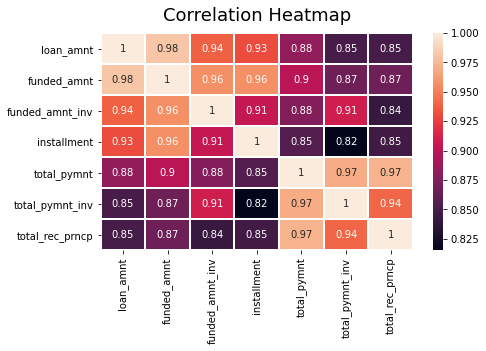

In [47]:
# visualize correlation of highly correlated (> 0.91) features with heatmap 
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
high_corr_heatmap = sns.heatmap(high_corr_subset.corr(), annot = True, linewidth=1, linecolor="white")
high_corr_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [48]:
# drop features that are highly correlated (keep just one feature in the matrix)
X_train.drop(columns = corr_features, inplace = True)
X_test.drop(columns = corr_features, inplace = True)

X_train.shape, X_test.shape

((31391, 97), (7848, 97))

In [49]:
X_train.head()

,loan_amnt,int_rate,annual_inc,dti,revol_bal,revol_util,total_pymnt,last_pymnt_amnt,pub_rec_bankruptcies,fico_range,last_fico_range,term_60 months,emp_length_10+ years,emp_length_3 - 5 years,emp_length_6 - 9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_2008,issue_d_2009,issue_d_2010,issue_d_2011,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,delinq_2yrs_1,delinq_2yrs_2+,inq_last_6mths_1,inq_last_6mths_2+,pub_rec_1+,recoveries_1+,open_acc_quartile_2nd quartile,open_acc_quartile_3rd quartile,open_acc_quartile_4th quartile
7665,30000.00,13.49,73300.00,5.27,19624.00,53.90,40095.58,11511.82,0.00,742.00,772.00,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32856,4300.00,11.83,108000.00,17.63,15050.00,28.90,5129.67,156.71,0.00,707.00,702.00,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1727,25000.00,22.06,180000.00,7.04,11260.00,78.70,10228.09,691.33,0.00,672.00,587.00,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
26164,10000.00,7.51,60000.00,12.94,7900.00,15.60,11052.35,3917.85,0.00,762.00,722.00,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4190,20000.00,12.69,74000.00,15.55,22739.00,62.50,24152.25,691.38,0.00,712.00,687.00,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### 6.2.2. correlation between features and outcome (explanatory variables and target)
- another assumption for regression is also that there is some correlation between explanatory variables and target variable

In [50]:
# temporary concatenate X_train data frame with y_train series and check the dimension - OK!
temp_concat_X_y = pd.concat([X_train, y_train], axis = 1)

temp_concat_X_y.shape

(31391, 98)

In [51]:
abs(temp_concat_X_y.corr()["loan_status"]).reset_index(name = "corr_with_target").sort_values("corr_with_target", ascending = False).head(60)

,index,corr_with_target
97,loan_status,1.00
93,recoveries_1+,0.85
10,last_fico_range,0.49
6,total_pymnt,0.23
7,last_pymnt_amnt,0.22
1,int_rate,0.21
11,term_60 months,0.16
9,fico_range,0.13
5,revol_util,0.10
36,purpose_small_business,0.08


# B. Model building
- Logistic Regression
- Decission Tree and Random Forest

## 1 Logistic Regression
1. using standard scaler
2. using robust scaler (deals better with data that contain outliers)
3. using data as it is (no scaler)

pick the best performing LogReg model and try LASSO?

In [52]:
# look at the means of features
X_train.mean().head(), X_train.mean().tail()

(loan_amnt    11114.47
 int_rate        11.98
 annual_inc   68860.17
 dti             13.28
 revol_bal    13275.86
 dtype: float64,
 pub_rec_1+                       0.05
 recoveries_1+                    0.11
 open_acc_quartile_2nd quartile   0.29
 open_acc_quartile_3rd quartile   0.21
 open_acc_quartile_4th quartile   0.21
 dtype: float64)

In [53]:
# look at the standard deviation of features
X_train.std().head(), X_train.std().tail()

(loan_amnt     7389.17
 int_rate         3.72
 annual_inc   65997.67
 dti              6.67
 revol_bal    15777.19
 dtype: float64,
 pub_rec_1+                       0.23
 recoveries_1+                    0.31
 open_acc_quartile_2nd quartile   0.46
 open_acc_quartile_3rd quartile   0.40
 open_acc_quartile_4th quartile   0.40
 dtype: float64)

## 1.1 LogisticRegression - standard scaler

In [54]:
# scaling features using standard scaler
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler().fit(X_train)

In [55]:
# transform
X_train_standard_scaled = standard_scaler.transform(X_train) 

In [56]:
# check mean and SD of scaled X_train - OK!
X_train_standard_scaled.mean(), X_train_standard_scaled.std()

(7.301614193684621e-18, 1.0)

In [57]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression() # create object of class LogReg
model1.fit(X_train_standard_scaled, y_train) # use standard scaled X_train to train model
model1.score(X_train_standard_scaled, y_train) # calculate accuracy of the model

0.9880857570641267

In [58]:
# calculate model accuracy on test data set
model1.score(X_test, y_test)

0.9074923547400612

In [59]:
pred_test = model1.predict_proba(X_test)
pred_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [60]:
pred_test = pred_test[:, 1]
pred_test

array([1., 1., 1., ..., 1., 1., 1.])

In [61]:
# calculate AUC score
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true = y_test, y_score = pred_test)

0.6875016901554943

## 1.2 LogisticRegression - robust scaler

In [62]:
# If data contains many outliers, scaling using the mean and variance of the data is likely to not work very well.
# In these cases, RobustScaler is better. It uses more robust estimates for the center and range of your data.
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler().fit(X_train)

In [63]:
X_train_robust_scaled = robust_scaler.transform(X_train)

In [64]:
# check mean and SD of scaled X_train
X_train_robust_scaled.mean(), X_train_robust_scaled.std()

(0.07448648052997604, 0.41368366201730566)

In [65]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train_robust_scaled, y_train) # use robust scaled X_train
model2.score(X_train_robust_scaled, y_train)

0.9869070752763531

In [66]:
model2.score(X_test, y_test)

0.9347604485219164

In [67]:
pred_test = model2.predict_proba(X_test)
pred_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [68]:
pred_test = pred_test[:, 1]
pred_test

array([1., 1., 1., ..., 1., 1., 1.])

In [69]:
# calculate AUC score
roc_auc_score(y_true = y_test, y_score = pred_test)

0.7879794841125384

## 1.3 LogisticRegression - no scaler

In [70]:
model3 = LogisticRegression(max_iter = 10000)
model3.fit(X_train, y_train) # use X_train
model3.score(X_train, y_train)

0.9848682743461502

In [71]:
model3.score(X_test, y_test)

0.9845820591233435

In [72]:
# classification prediction (i. e. class 0 or 1) for each observation in X_test
# note. threshold set up to 0.5 by default!!
class_pred_test = model3.predict(X_test)
class_pred_test

array([1, 1, 1, ..., 1, 0, 0])

In [73]:
# probability prediction (range 0 to 1) for each observation in X_test
pred_test = model3.predict_proba(X_test)
pred_test

array([[9.19648513e-03, 9.90803515e-01],
       [8.93252962e-04, 9.99106747e-01],
       [2.32558709e-03, 9.97674413e-01],
       ...,
       [3.22160953e-02, 9.67783905e-01],
       [9.94820298e-01, 5.17970189e-03],
       [9.89643509e-01, 1.03564915e-02]])

In [74]:
# keep the probabilities of possitive class only - client paying the loan (= 1)
pred_test = pred_test[:, 1]
pred_test

array([0.99080351, 0.99910675, 0.99767441, ..., 0.9677839 , 0.0051797 ,
       0.01035649])

In [75]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, class_pred_test)

array([[1051,   97],
       [  24, 6676]])

In [76]:
# accuracy = [accuracy,f1-score]; ((TP + TN) / N)
from sklearn.metrics import accuracy_score

accuracy_score(y_test, class_pred_test)

0.9845820591233435

In [77]:
# sensitivity = [weighted avg, precision]; (TP / (TP+FN))
# specificity (= weighted avg, recall) (TP / (TP+FP)
from sklearn.metrics import classification_report

print(classification_report(y_test, class_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1148
           1       0.99      1.00      0.99      6700

    accuracy                           0.98      7848
   macro avg       0.98      0.96      0.97      7848
weighted avg       0.98      0.98      0.98      7848



In [78]:
# calculate AUC score 
AUC = roc_auc_score(y_true = y_test, y_score = pred_test)
AUC

0.9953138488740964

In [79]:
## visualize ROC
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [80]:
# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
# thresholds

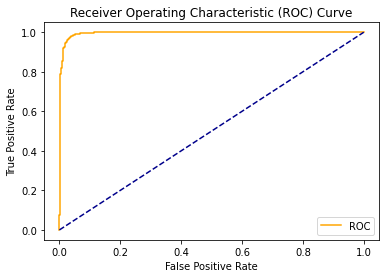

In [81]:
plot_roc_curve(fpr, tpr)

In [116]:
# selecting optimal threshold for best accuracy of the binary classifier for imbalanced 
# choose the point closest to the top left corner of ROC curve, the threshold used to generate this point is the optimal one
# the optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low
from sklearn.metrics import accuracy_score

accuracy_LR = []

for thres in thresholds:
    y_pred = np.where(pred_test > thres, 1, 0)
    accuracy_LR.append(accuracy_score(y_test, y_pred, normalize = True))
    
accuracy_LR = pd.concat([pd.Series(thresholds), pd.Series(accuracy_LR)], axis = 1)

accuracy_LR.columns = ["threshold", "accuracy"]
accuracy_LR.sort_values(by = "accuracy", ascending = False, inplace = True)
accuracy_LR.head()

,threshold,accuracy
9,0.60,0.99
8,0.65,0.98
10,0.55,0.98
7,0.70,0.98
11,0.50,0.98


In [114]:
# pull out threshold with the highest accuracy
opt_thres = accuracy_LR.iloc[0,0]
opt_thres

0.6

In [123]:
# classification prediction (i. e. class 0 or 1) for each observation in X_test threshold set to optimum
class_pred_test = (model3.predict(X_test) >= opt_thres).astype(int)
class_pred_test

array([1, 1, 1, ..., 1, 0, 0])

## 2 Decision Tree and Random Forest

### 2.1 Decision Tree

In [85]:
from sklearn import tree

model4 = tree.DecisionTreeClassifier(max_features = 3, max_depth = 5)
model4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=3)

In [86]:
model4.score(X_test, y_test)

0.8845565749235474

In [87]:
# predict probabilities for test data
pred_test = model4.predict_proba(X_test)

In [88]:
# keep probabilities of the positive class only
pred_test = pred_test[:, 1]

In [89]:
# calculate AUC score
AUC = roc_auc_score(y_true = y_test, y_score = pred_test)
AUC

0.7331251625149514

In [90]:
# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)

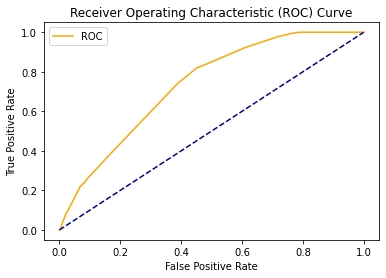

In [91]:
# plot ROC curve
plot_roc_curve(fpr, tpr)

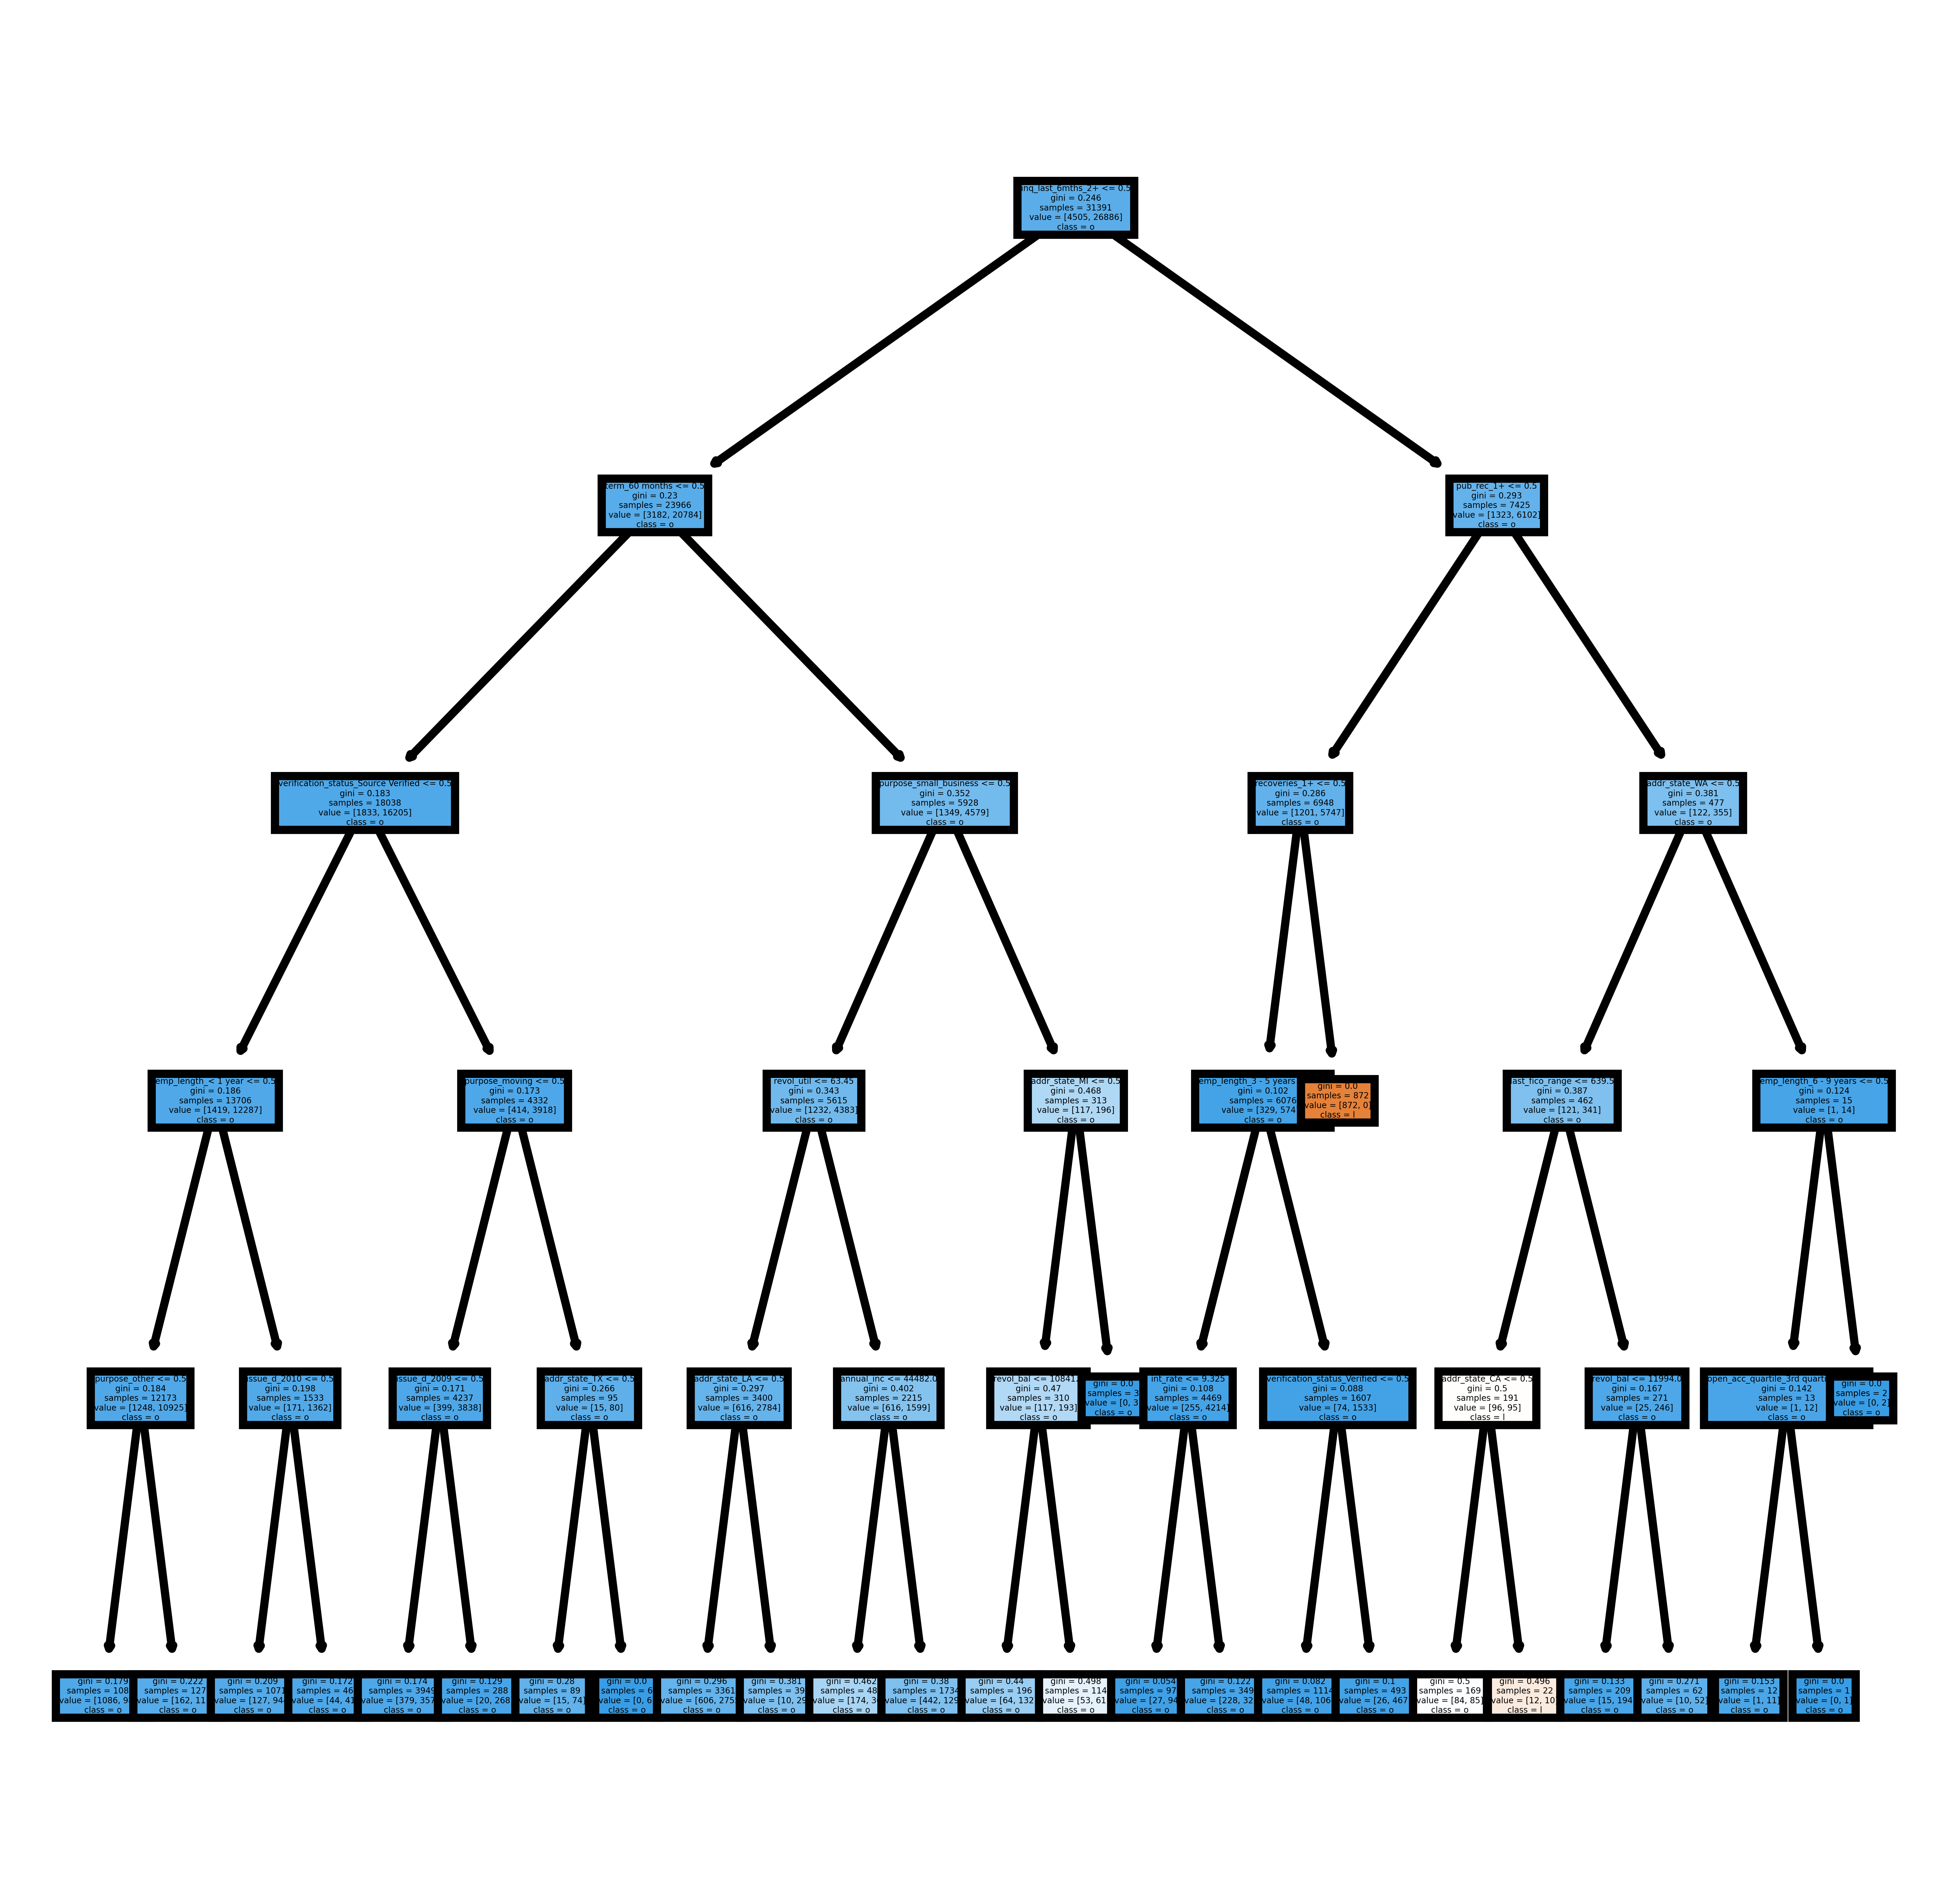

In [92]:
# visualization 
fn = X_test.columns # feature names
cn = y_test.name # target name

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 2000)

tree.plot_tree(model4,
               feature_names = fn,
               class_names = cn,
               filled = True);

fig.savefig("model4_decision_tree.jpg")

### 2.2 Random Forest
- utilizes bootstraping to generate defined amount of Decision Trees

In [93]:
from sklearn.ensemble import RandomForestClassifier

model5 = RandomForestClassifier(n_estimators = 20)

model5.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [94]:
model5.score(X_test, y_test)

0.9811416921508664

In [95]:
# predict probabilities for test data
pred_test = model5.predict_proba(X_test)

In [96]:
# keep probabilities of the positive class only
pred_test = pred_test[:, 1]

In [97]:
# calculate AUC score
AUC = roc_auc_score(y_true = y_test, y_score = pred_test)
AUC

0.9907411331842529

In [98]:
# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)

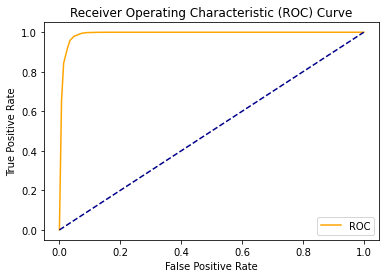

In [99]:
# plot ROC curve
plot_roc_curve(fpr, tpr)

In [117]:
# selecting optimal threshold for best accuracy of the binary classifier for imbalanced data set
accuracy_RF = []

for thres in thresholds:
    y_pred = np.where(pred_test > thres, 1, 0)
    accuracy_RF.append(accuracy_score(y_test, y_pred, normalize = True))
    
accuracy_RF = pd.concat([pd.Series(thresholds), pd.Series(accuracy_RF)], axis = 1)

accuracy_RF.columns = ["threshold", "accuracy"]
accuracy_RF.sort_values(by = "accuracy", ascending = False, inplace = True)
accuracy_RF.head()

,threshold,accuracy
9,0.60,0.99
8,0.65,0.98
10,0.55,0.98
7,0.70,0.98
11,0.50,0.98


In [118]:
# pull out threshold with the highest accuracy
opt_thres = accuracy_RF.iloc[0,0]
opt_thres

0.6

In [119]:
# probability prediction (range 0 to 1) for each observation in X_test with optimal threshold
decisions = (model5.predict_proba(X_test) >= opt_thres).astype(int)
decisions

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

## Model showcase

In [153]:
# pick 10 random observations (client) from the test set and make prediction
# compare predicted class with the actual class
concat_test = pd.concat([y_test, X_test], axis = 1)
client_sample = concat_test.sample(10)
client_sample

,loan_status,loan_amnt,int_rate,annual_inc,dti,revol_bal,revol_util,total_pymnt,last_pymnt_amnt,pub_rec_bankruptcies,fico_range,last_fico_range,term_60 months,emp_length_10+ years,emp_length_3 - 5 years,emp_length_6 - 9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_2008,issue_d_2009,issue_d_2010,issue_d_2011,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,delinq_2yrs_1,delinq_2yrs_2+,inq_last_6mths_1,inq_last_6mths_2+,pub_rec_1+,recoveries_1+,open_acc_quartile_2nd quartile,open_acc_quartile_3rd quartile,open_acc_quartile_4th quartile
29747,1,10000.00,9.88,45000.00,7.44,8035.00,47.50,11594.05,671.61,0.00,727.00,772.00,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
33881,1,24250.00,12.53,140000.00,20.28,60713.00,62.50,27565.43,15409.47,0.00,722.00,727.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
23093,1,12000.00,12.23,54000.00,9.93,15010.00,82.90,14397.80,430.26,0.00,687.00,672.00,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16562,1,17000.00,11.11,88000.00,16.62,10333.00,25.80,21205.44,8648.20,0.00,762.00,737.00,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
38298,0,7000.00,15.57,48500.00,2.72,3273.00,69.60,2931.24,244.62,0.00,672.00,657.00,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
38635,1,5000.00,8.32,30792.00,10.13,20337.00,39.20,5667.12,157.41,0.00,742.00,777.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
28509,1,25000.00,11.86,720000.00,1.98,27892.00,48.60,30471.98,806.25,0.00,757.00,727.00,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
17370,0,35000.00,14.91,75000.00,12.10,2131.00,7.10,7476.92,831.00,0.00,752.00,682.00,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
20066,1,25000.00,19.74,75000.00,19.73,18443.00,82.10,33328.49,974.55,0.00,667.00,702.00,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
13704,1,1000.00,6.99,41000.00,8.08,0.00,0.00,1055.06,14.63,0.00,737.00,537.00,0,0,0,0,1,0,0,1,0,0,0,0,0,

In [156]:
# assign X as a DataFrame of features (explanatory matrix), and y as Series (Outcome variable)
X_sample = client_sample.drop(columns = "loan_status")
y_sample = client_sample["loan_status"]

# make prediction
class_pred_sample = (model3.predict(X_sample) >= opt_thres).astype(int) # change to whichever model you want (1-5)
class_pred_sample

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [157]:
# was the prediction right?
print(client_sample.loc[:, "loan_status"] == class_pred_sample)
print()

29747    True
33881    True
23093    True
16562    True
38298    True
38635    True
28509    True
17370    True
20066    True
13704    True
Name: loan_status, dtype: bool



In [101]:
# those are just ideas... :)

## ?? Feature selection using forward selection
make a classification model with each of the features, select the one with the best performance
then make two dimensional model, and again choose the one with best performation etc

In [102]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [103]:
sfs1 = SFS()

TypeError: __init__() missing 1 required positional argument: 'estimator'

## ?? Features selection based on Mutual Information
- MI between two random variables measures the dependency between the variables
- MI = 0, if they are independent, higher values mean higher dependency
- the function relies on nonparametric methods based on enthropy estimation from k-nearest neighbors distance
- i.e. MI tells us how much information I can obtain from one random variable given another

In [ ]:
from sklearn.feature_selection import mutual_info_classif
# determine the MI
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info